In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import pandas as pd
import datetime

In [2]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cpu


In [3]:
def model_parameters(model):
    print("Model 1 state dict:")
    print(f"Device: {next(model.parameters()).device}")
    for name, param in model.state_dict().items():
        print(f"{name}:")
        print(f"  Shape: {param.shape}")
        print(f"  Device: {param.device}")
        print(f"  Values: {param[:1]}")
        print("-" * 50)

Shape of X: (1000, 5)
Shape of y: (1000,)
Unique labels: {np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9)}
   Feature_1  Feature_2  Feature_3  Feature_4  Feature_5  Label
0   1.387211   0.708945   0.931566   1.632102   0.351849      9
1  -0.046376   0.919981   2.486990  -1.345069   1.390708      3
2   1.775544  -0.380423  -0.253636   2.176995  -0.091527      2
3   1.184893  -0.070969  -1.844862   1.433614  -1.326704      4
4  -1.783947  -1.009438   1.520961  -0.168897   1.580889      8


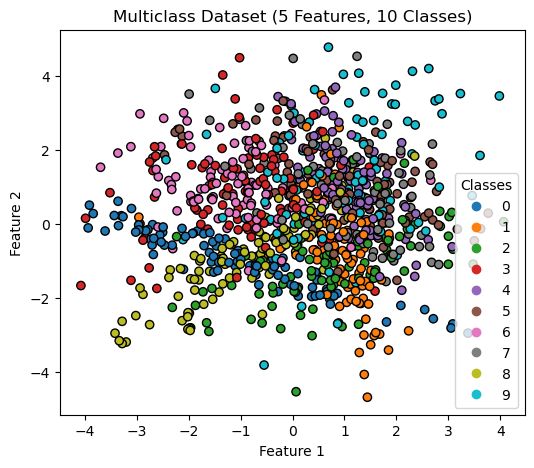

In [4]:
from sklearn.datasets import make_classification
import matplotlib.pyplot as plt
import pandas as pd

# Create dataset
X, y = make_classification(
    n_samples=1000,     # total samples
    # n_informative + n_redundant + n_repeated ≤ n_features
    n_features=5,       # number of features
    n_informative=4,    # Directly influence class labels (determine y)
    n_redundant=1,      # no redundant features (Linear combinations of informative ones)
    n_repeated=0,       # Exact copies of others
    n_classes=10,       # number of target classes
    n_clusters_per_class=1,
    random_state=42
)

# Show dataset info
print("Shape of X:", X.shape)
print("Shape of y:", y.shape)
print("Unique labels:", set(y))

# Convert to DataFrame for visualization
df = pd.DataFrame(X, columns=[f"Feature_{i+1}" for i in range(5)])
df["Label"] = y
print(df.head())

# Visualize first 2 features (just for intuition)
plt.figure(figsize=(6, 5))
scatter = plt.scatter(X[:, 0], X[:, 1], c=y, cmap="tab10", edgecolors="k")
plt.title("Multiclass Dataset (5 Features, 10 Classes)")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend(*scatter.legend_elements(), title="Classes")
plt.show()


In [5]:
# Create a dataset for: tarin=70%, test=10%, Validation=30%
def split_train_test_val(features, targets, train_rate = 0.7, test_rate = 0.1, val_rate = 0.2):

    """
        * For multiclass classification
            - CrossEntropyLoss expects:
                - Model output shape: [batch_size, num_classes]
                - Target shape: [batch_size] with integer class labels (0 to num_classes-1)
                - Do not reshape the target to [batch_size, 1].

        * Use dtype=torch.float32 for features.
        * Use dtype=torch.long for targets (integers).
        * Do not reshape targets for CrossEntropyLoss.
    """
    size_train = int(len(features)*train_rate)
    size_test =  int(len(features)*test_rate)

    # nn.Linear expects floating-point inputs (float32 or float64), not integers.
    #Targets should be long (integers), which is correct for CrossEntropyLoss.
    
    train_features = torch.tensor(features[:size_train], dtype=torch.float32).to(device)
    train_targets = torch.tensor(targets[:size_train], dtype=torch.long).to(device)

    test_features = torch.tensor(features[size_train:size_train+size_test], dtype=torch.float32).to(device)
    test_targets = torch.tensor(targets[size_train:size_train+size_test], dtype=torch.long).to(device)

    val_features = torch.tensor(features[size_train+size_test:], dtype=torch.float32).to(device)
    val_targets = torch.tensor(targets[size_train+size_test:], dtype=torch.long).to(device)


    return train_features, train_targets, test_features, test_targets, val_features, val_targets

In [6]:
X_train, y_train, X_test, y_test, X_val, y_val = split_train_test_val(X, y, train_rate = 0.7, test_rate = 0.1, val_rate = 0.2)

In [7]:
print(f" X_train: {len(X_train)}, {X_train.shape}, || X_test: {len(X_test)}, {X_test.shape}"
      f" || X_validation: {len(X_val)}, {X_val.shape}")
print(X_train[:2])
print(y_train[:2])

 X_train: 700, torch.Size([700, 5]), || X_test: 100, torch.Size([100, 5]) || X_validation: 200, torch.Size([200, 5])
tensor([[ 1.3872,  0.7089,  0.9316,  1.6321,  0.3518],
        [-0.0464,  0.9200,  2.4870, -1.3451,  1.3907]])
tensor([9, 3])


In [8]:
class SimpleMultiClassClassification(nn.Module):
    def __init__(self, input_size=5, hidden_size = 16, output_size=10):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, output_size)
        )

    def forward(self, x):
        return self.net(x)

In [9]:
"""
    * Use CrossEntropyLoss, not BCELoss, for multiclass.
"""

learning_rate = 0.01
model_1 = SimpleMultiClassClassification(input_size=5, hidden_size=16, output_size=10).to(device)
criterion = nn.CrossEntropyLoss() # For multiclass classification
optimizer = optim.Adam(model_1.parameters(), lr=learning_rate)

In [10]:
print(model_parameters(model_1))

Model 1 state dict:
Device: cpu
net.0.weight:
  Shape: torch.Size([16, 5])
  Device: cpu
  Values: tensor([[-0.4311,  0.2129, -0.0485,  0.3308,  0.1738]])
--------------------------------------------------
net.0.bias:
  Shape: torch.Size([16])
  Device: cpu
  Values: tensor([0.2947])
--------------------------------------------------
net.2.weight:
  Shape: torch.Size([10, 16])
  Device: cpu
  Values: tensor([[-0.0681, -0.0173,  0.1917,  0.2016, -0.1176,  0.0196,  0.0234,  0.2219,
          0.0128,  0.0438,  0.1670,  0.2221, -0.2387,  0.1526,  0.1510,  0.1245]])
--------------------------------------------------
net.2.bias:
  Shape: torch.Size([10])
  Device: cpu
  Values: tensor([0.1234])
--------------------------------------------------
None


In [11]:
# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    correct = (y_pred == y_true).float().sum()
    acc = correct / len(y_true)
    return acc * 100

In [12]:
def train_model(model, train_features, train_targets, test_features, test_targets, epochs=50):
    
    train_losses, test_losses, train_accuracies, test_accuracies = [], [], [], []

    for epoch in range(epochs):
        model.train()
        
        train_predictions = model(train_features)
        train_loss = criterion(train_predictions, train_targets)
        
        # For multiclass classification - get predicted class
        train_predicted = torch.argmax(train_predictions, dim=1)
        train_accuracy = accuracy_fn(y_true=train_targets, y_pred=train_predicted)

        # Backward pass and optimization
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        # Evaluation phase
        model.eval()
        with torch.no_grad():
            test_predictions = model(test_features)
            test_loss = criterion(test_predictions, test_targets)
       
            # For multiclass classification - get predicted class
            test_predicted = torch.argmax(test_predictions, dim=1)
            test_accuracy = accuracy_fn(y_true=test_targets, y_pred=test_predicted)

        train_losses.append(train_loss.item())
        test_losses.append(test_loss.item())
        train_accuracies.append(train_accuracy)
        test_accuracies.append(test_accuracy)

        # Print every 10 epochs
        if epoch % 10 == 0:
            print(f"Epoch [{epoch}/{epochs}] | "
                  f"Train Loss: {train_loss.item():.4f} | Train Acc: {train_accuracy:.2f}% | "
                  f"Test Loss: {test_loss.item():.4f} | Test Acc: {test_accuracy:.2f}%")

    return train_losses, test_losses, train_accuracies, test_accuracies

In [13]:
# Train the model_1
print("Model is going to training ...")
train_losses_model_1, test_losses_model_1, train_accuracies_model_1, test_accuracies_model_1 = train_model(
    model_1, X_train, y_train, X_test, y_test, epochs=100)

Model is going to training ...
Epoch [0/100] | Train Loss: 2.2870 | Train Acc: 13.57% | Test Loss: 2.2194 | Test Acc: 17.00%
Epoch [10/100] | Train Loss: 1.8890 | Train Acc: 40.57% | Test Loss: 1.7677 | Test Acc: 44.00%
Epoch [20/100] | Train Loss: 1.5254 | Train Acc: 52.86% | Test Loss: 1.4289 | Test Acc: 64.00%
Epoch [30/100] | Train Loss: 1.2467 | Train Acc: 62.43% | Test Loss: 1.2256 | Test Acc: 63.00%
Epoch [40/100] | Train Loss: 1.0950 | Train Acc: 66.29% | Test Loss: 1.1019 | Test Acc: 67.00%
Epoch [50/100] | Train Loss: 1.0052 | Train Acc: 69.57% | Test Loss: 1.0589 | Test Acc: 66.00%
Epoch [60/100] | Train Loss: 0.9404 | Train Acc: 70.29% | Test Loss: 1.0208 | Test Acc: 71.00%
Epoch [70/100] | Train Loss: 0.8927 | Train Acc: 71.71% | Test Loss: 0.9978 | Test Acc: 69.00%
Epoch [80/100] | Train Loss: 0.8544 | Train Acc: 72.71% | Test Loss: 0.9797 | Test Acc: 74.00%
Epoch [90/100] | Train Loss: 0.8215 | Train Acc: 73.14% | Test Loss: 0.9591 | Test Acc: 73.00%


In [14]:
print(model_1)

SimpleMultiClassClassification(
  (net): Sequential(
    (0): Linear(in_features=5, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=10, bias=True)
  )
)


In [15]:
print(summary(model_1, input_size=X_train.shape))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1              [-1, 700, 16]              96
              ReLU-2              [-1, 700, 16]               0
            Linear-3              [-1, 700, 10]             170
Total params: 266
Trainable params: 266
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.22
Params size (MB): 0.00
Estimated Total Size (MB): 0.24
----------------------------------------------------------------
None


In [16]:
def evaluate_model(model, val_features, val_targets):
    model.eval()
    with torch.no_grad():
        val_predictions = model(val_features)
        loss = criterion(val_predictions, val_targets)
        
        val_predicted = torch.argmax(val_predictions, dim=1)
        val_accuracy = accuracy_fn(y_true=val_targets, y_pred=val_predicted)
        
        return loss.item(), val_accuracy

val_loss, val_accuracy = evaluate_model(model_1, X_val, y_val)
print(f"Validation loss is {val_loss}, || Validation accuracy is {val_accuracy}")

Validation loss is 0.9170969128608704, || Validation accuracy is 69.5


In [17]:
def predict(model, features):
    model.eval()
    with torch.no_grad():
        # Ensure input is float tensor
        input_tensor = torch.tensor(features, dtype=torch.float32)
        output = model(input_tensor)
        predict = torch.argmax(output)

        return predict

features = [-2, 0, 3, 4, 1]
predict_label = predict(model_1, features)

print(f"Predicted class is: {predict_label}")

Predicted class is: 3


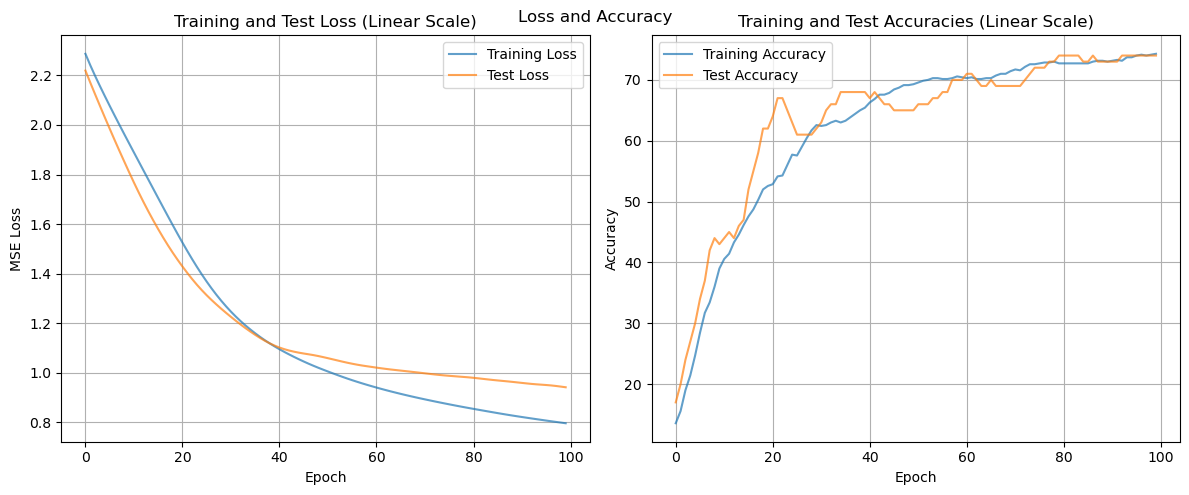

In [18]:
# Plot training and test losses

def plot_loss_accuracy(train_losses, test_losses, train_accuracies, test_accuracies, alpha=0.7):

    fig, axes = plt.subplots(1,2,figsize=(12, 5)) 

    axes[0].plot(train_losses, label='Training Loss', alpha=0.7)
    axes[0].plot(test_losses, label='Test Loss', alpha=0.7)
    axes[0].set_title("Training and Test Loss (Linear Scale)")
    axes[0].set_xlabel("Epoch")
    axes[0].set_ylabel("MSE Loss")
    axes[0].legend()
    axes[0].grid(True)

    axes[1].plot(train_accuracies, label='Training Accuracy', alpha=0.7)
    axes[1].plot(test_accuracies, label='Test Accuracy', alpha=0.7)
    axes[1].set_title("Training and Test Accuracies (Linear Scale)")
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    axes[1].grid(True)

    # Adjust spacing between subplots
    plt.tight_layout()
    
    fig.suptitle('Loss and Accuracy')

    plt.show()

plot_loss_accuracy(train_losses_model_1, test_losses_model_1, train_accuracies_model_1, test_accuracies_model_1)

In [19]:
# Simple DataLoader Creation

def create_dataloaders_from_split(train_features, train_targets, test_features, test_targets, val_features, val_targets, batch_size=32):
    """
    Create DataLoaders from already split data
    """
    # Create TensorDatasets
    train_dataset = TensorDataset(train_features, train_targets)
    test_dataset = TensorDataset(test_features, test_targets)
    val_dataset = TensorDataset(val_features, val_targets)
    
    # Create DataLoaders
    train_loader = DataLoader(
        train_dataset, 
        batch_size=batch_size, 
        shuffle=True,  # Shuffle training data
        drop_last=True  # Drop last incomplete batch
    )
    
    test_loader = DataLoader(
        test_dataset, 
        batch_size=batch_size, 
        shuffle=False  # No shuffle for testing
    )
    
    val_loader = DataLoader(
        val_dataset, 
        batch_size=batch_size, 
        shuffle=False  # No shuffle for validation
    )
    
    # Print dataset sizes
    print(f"Training samples: {len(train_dataset)}")
    print(f"Validation samples: {len(val_dataset)}")
    print(f"Test samples: {len(test_dataset)}")
    print(f"Training batches: {len(train_loader)}")
    print(f"Validation batches: {len(val_loader)}")
    print(f"Test batches: {len(test_loader)}")
    
    return train_loader, test_loader, val_loader

In [20]:
train_loader, test_loader, val_loader = create_dataloaders_from_split(X_train, y_train, X_test, y_test, X_val, y_val, batch_size=32)

Training samples: 700
Validation samples: 200
Test samples: 100
Training batches: 21
Validation batches: 7
Test batches: 4


In [21]:
def train_model_with_dataLoader(model, train_loader, test_loader, epochs=100):
    train_losses, test_losses, train_accuracies, test_accuracies = [], [], [], []

    for epoch in range(epochs):
        model.train()
        epoch_train_loss, epoch_train_acc = 0., 0.

        for train_features, train_targets in train_loader:
            
            train_predictions = model(train_features)
            train_loss = criterion(train_predictions, train_targets)
            
            # For multiclass classification - get predicted class
            train_predicted = torch.argmax(train_predictions, dim=1)
            train_accuracy = accuracy_fn(y_true=train_targets, y_pred=train_predicted)
    
            # Backward pass and optimization
            optimizer.zero_grad()
            train_loss.backward()
            optimizer.step()

            epoch_train_loss += train_loss.item()
            epoch_train_acc += train_accuracy

        # Average over all batches
        epoch_train_loss /= len(train_loader)
        epoch_train_acc /= len(train_loader)

        # Evaluation phase
        model.eval()
        epoch_test_loss, epoch_test_acc = 0., 0.
        with torch.no_grad():
            for test_features, test_targets in test_loader:
                test_predictions = model(test_features)
                test_loss = criterion(test_predictions, test_targets)
           
                # For multiclass classification - get predicted class
                test_predicted = torch.argmax(test_predictions, dim=1)
                test_accuracy = accuracy_fn(y_true=test_targets, y_pred=test_predicted)
    
                epoch_test_loss += test_loss.item()
                epoch_test_acc += test_accuracy

        # Average over all batches
        epoch_test_loss /= len(test_loader)
        epoch_test_acc /= len(test_loader)

        # Store results
        train_losses.append(epoch_train_loss)
        test_losses.append(epoch_test_loss)
        train_accuracies.append(epoch_train_acc)
        test_accuracies.append(epoch_test_acc)

        # Print every 100 epochs
        if epoch % 10 == 0:
            print(f"Epoch [{epoch}/{epochs}] | "
                  f"Train Loss: {epoch_train_loss:.4f} | Train Acc: {epoch_train_acc:.2f}% | "
                  f"Test Loss: {epoch_test_loss:.4f} | Test Acc: {epoch_test_acc:.2f}%")


    return train_losses, test_losses, train_accuracies, test_accuracies   
            

In [22]:
class TwoHiddenLayersMultiClassClassification(nn.Module):
    def __init__(self, input_size=5, hidden_size = 16, output_size=10):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size//2),
            nn.ReLU(),
            nn.Linear(hidden_size//2, output_size)
        )

    def forward(self, x):
        return self.net(x)

In [23]:
learning_rate = 0.01
model_2 = TwoHiddenLayersMultiClassClassification(input_size=5, hidden_size=32, output_size=10).to(device)
criterion = nn.CrossEntropyLoss() # For multiclass classification
optimizer = optim.Adam(model_2.parameters(), lr=learning_rate)

In [24]:
print(model_2)

TwoHiddenLayersMultiClassClassification(
  (net): Sequential(
    (0): Linear(in_features=5, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=16, bias=True)
    (3): ReLU()
    (4): Linear(in_features=16, out_features=10, bias=True)
  )
)


In [25]:
print(summary(model_2, input_size=X_train.shape))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1              [-1, 700, 32]             192
              ReLU-2              [-1, 700, 32]               0
            Linear-3              [-1, 700, 16]             528
              ReLU-4              [-1, 700, 16]               0
            Linear-5              [-1, 700, 10]             170
Total params: 890
Trainable params: 890
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.57
Params size (MB): 0.00
Estimated Total Size (MB): 0.58
----------------------------------------------------------------
None


In [26]:
# Train the model_1
print("Model is going to training ...")
train_losses_model_2, test_losses_model_2, train_accuracies_model_2, test_accuracies_model_2 = train_model_with_dataLoader(
    model_2, train_loader, test_loader, epochs=100)

Model is going to training ...
Epoch [0/100] | Train Loss: 1.9971 | Train Acc: 32.44% | Test Loss: 1.7166 | Test Acc: 47.66%
Epoch [10/100] | Train Loss: 0.7429 | Train Acc: 73.51% | Test Loss: 0.9489 | Test Acc: 68.75%
Epoch [20/100] | Train Loss: 0.6104 | Train Acc: 78.27% | Test Loss: 0.8533 | Test Acc: 72.66%
Epoch [30/100] | Train Loss: 0.5427 | Train Acc: 79.46% | Test Loss: 0.8293 | Test Acc: 77.34%
Epoch [40/100] | Train Loss: 0.4359 | Train Acc: 84.23% | Test Loss: 0.8344 | Test Acc: 78.91%
Epoch [50/100] | Train Loss: 0.4275 | Train Acc: 84.52% | Test Loss: 0.8384 | Test Acc: 78.12%
Epoch [60/100] | Train Loss: 0.4015 | Train Acc: 84.82% | Test Loss: 0.8533 | Test Acc: 78.91%
Epoch [70/100] | Train Loss: 0.3276 | Train Acc: 88.10% | Test Loss: 1.0941 | Test Acc: 68.75%
Epoch [80/100] | Train Loss: 0.3997 | Train Acc: 85.57% | Test Loss: 0.9053 | Test Acc: 83.59%
Epoch [90/100] | Train Loss: 0.3202 | Train Acc: 87.65% | Test Loss: 1.1127 | Test Acc: 75.00%


In [27]:
# Evaluate the model
val_loss, val_accuracy = evaluate_model(model_2, X_val, y_val)
print(f"Validation loss is {val_loss}, || Validation accuracy is {val_accuracy}")

Validation loss is 0.6365083456039429, || Validation accuracy is 84.5


In [28]:
# Predict the label of an input
features = [-2, 0, 3, 4, 1]
predict_label = predict(model_2, features)
print(f"Predicted class is: {predict_label}")

Predicted class is: 3


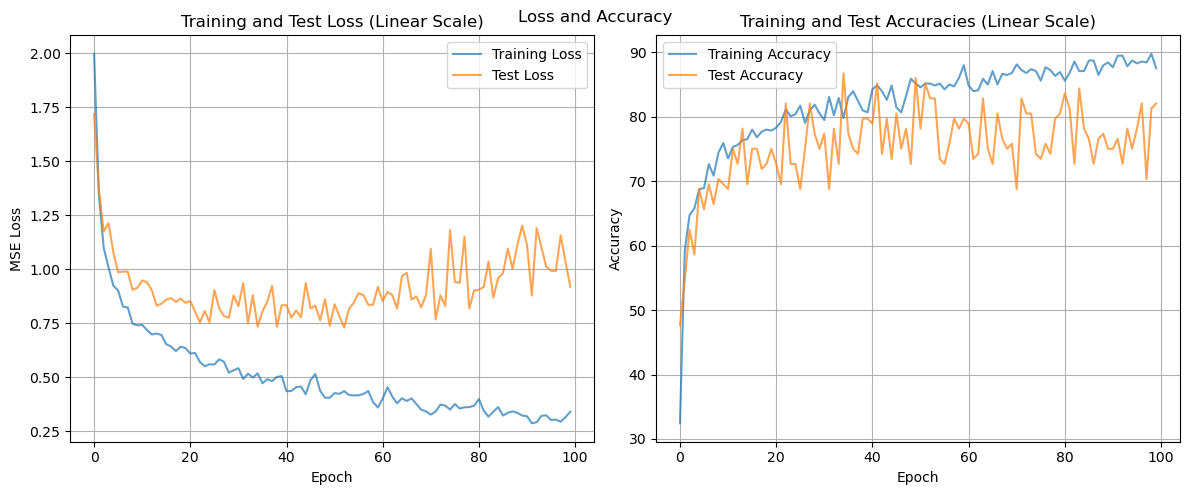

In [29]:
# Plot loss and accuracy
plot_loss_accuracy(train_losses_model_2, test_losses_model_2, train_accuracies_model_2, test_accuracies_model_2)

In [30]:
def train_model_with_dataLoader_early_stopping(model, train_loader, test_loader, epochs=100, patience=5):
    train_losses, test_losses, train_accuracies, test_accuracies = [], [], [], []
    best_loss, trigger_times = float('inf'), 0

    for epoch in range(epochs):
        model.train()
        epoch_train_loss, epoch_train_acc = 0., 0.

        for train_features, train_targets in train_loader:
            
            train_predictions = model(train_features)
            train_loss = criterion(train_predictions, train_targets)
            
            # For multiclass classification - get predicted class
            train_predicted = torch.argmax(train_predictions, dim=1)
            train_accuracy = accuracy_fn(y_true=train_targets, y_pred=train_predicted)
    
            # Backward pass and optimization
            optimizer.zero_grad()
            train_loss.backward()
            optimizer.step()

            epoch_train_loss += train_loss.item()
            epoch_train_acc += train_accuracy

        # Average over all batches
        epoch_train_loss /= len(train_loader)
        epoch_train_acc /= len(train_loader)

        # Evaluation phase
        model.eval()
        epoch_test_loss, epoch_test_acc = 0., 0.
        with torch.no_grad():
            for test_features, test_targets in test_loader:
                test_predictions = model(test_features)
                test_loss = criterion(test_predictions, test_targets)
           
                # For multiclass classification - get predicted class
                test_predicted = torch.argmax(test_predictions, dim=1)
                test_accuracy = accuracy_fn(y_true=test_targets, y_pred=test_predicted)
    
                epoch_test_loss += test_loss.item()
                epoch_test_acc += test_accuracy

        # Average over all batches
        epoch_test_loss /= len(test_loader)
        epoch_test_acc /= len(test_loader)

        # Store results
        train_losses.append(epoch_train_loss)
        test_losses.append(epoch_test_loss)
        train_accuracies.append(epoch_train_acc)
        test_accuracies.append(epoch_test_acc)

        # Print every 100 epochs
        if epoch % 10 == 0:
            print(f"Epoch [{epoch}/{epochs}] | "
                  f"Train Loss: {epoch_train_loss:.4f} | Train Acc: {epoch_train_acc:.2f}% | "
                  f"Test Loss: {epoch_test_loss:.4f} | Test Acc: {epoch_test_acc:.2f}%")

        # Early stopping
        if epoch_test_loss < best_loss:
            best_loss, trigger_times = epoch_test_loss, 0
        else:
            trigger_times += 1
            if trigger_times >= patience:
                print("Early stopping triggered!")
                break

    return train_losses, test_losses, train_accuracies, test_accuracies   
            

In [31]:
learning_rate = 0.01
model_3 = TwoHiddenLayersMultiClassClassification(input_size=5, hidden_size=16, output_size=10).to(device)
criterion = nn.CrossEntropyLoss() # For multiclass classification
optimizer = optim.Adam(model_3.parameters(), lr=learning_rate)

In [32]:
print(model_parameters(model_3))

Model 1 state dict:
Device: cpu
net.0.weight:
  Shape: torch.Size([16, 5])
  Device: cpu
  Values: tensor([[ 0.1130,  0.0840,  0.1152, -0.0253, -0.2523]])
--------------------------------------------------
net.0.bias:
  Shape: torch.Size([16])
  Device: cpu
  Values: tensor([0.1625])
--------------------------------------------------
net.2.weight:
  Shape: torch.Size([8, 16])
  Device: cpu
  Values: tensor([[-0.1735, -0.1198,  0.1763,  0.0139, -0.0010,  0.0133,  0.0608, -0.2464,
         -0.1138,  0.0660, -0.0232,  0.0687, -0.1845,  0.2428, -0.0975,  0.1452]])
--------------------------------------------------
net.2.bias:
  Shape: torch.Size([8])
  Device: cpu
  Values: tensor([0.0031])
--------------------------------------------------
net.4.weight:
  Shape: torch.Size([10, 8])
  Device: cpu
  Values: tensor([[-0.3025, -0.1433, -0.2586,  0.1378,  0.1247, -0.2796, -0.0962,  0.0878]])
--------------------------------------------------
net.4.bias:
  Shape: torch.Size([10])
  Device: cpu


In [33]:
# Train the model_1
print("Model is going to training ...")
train_losses_model_3, test_losses_model_3, train_accuracies_model_3, test_accuracies_model_3 = train_model_with_dataLoader_early_stopping(
    model_3, train_loader, test_loader, epochs=100, patience=10)

Model is going to training ...
Epoch [0/100] | Train Loss: 2.1643 | Train Acc: 23.36% | Test Loss: 1.9572 | Test Acc: 28.12%
Epoch [10/100] | Train Loss: 0.9089 | Train Acc: 68.90% | Test Loss: 1.0198 | Test Acc: 65.62%
Epoch [20/100] | Train Loss: 0.7915 | Train Acc: 73.51% | Test Loss: 1.0796 | Test Acc: 60.94%
Early stopping triggered!


In [34]:
# Evaluate the model
val_loss, val_accuracy = evaluate_model(model_3, X_val, y_val)
print(f"Validation loss is {val_loss}, || Validation accuracy is {val_accuracy}")

Validation loss is 0.914079487323761, || Validation accuracy is 72.5


In [35]:
# Predict the label of an input
features = [-2, 0, 3, 4, 1]
predict_label = predict(model_3, features)
print(f"Predicted class is: {predict_label}")

Predicted class is: 3


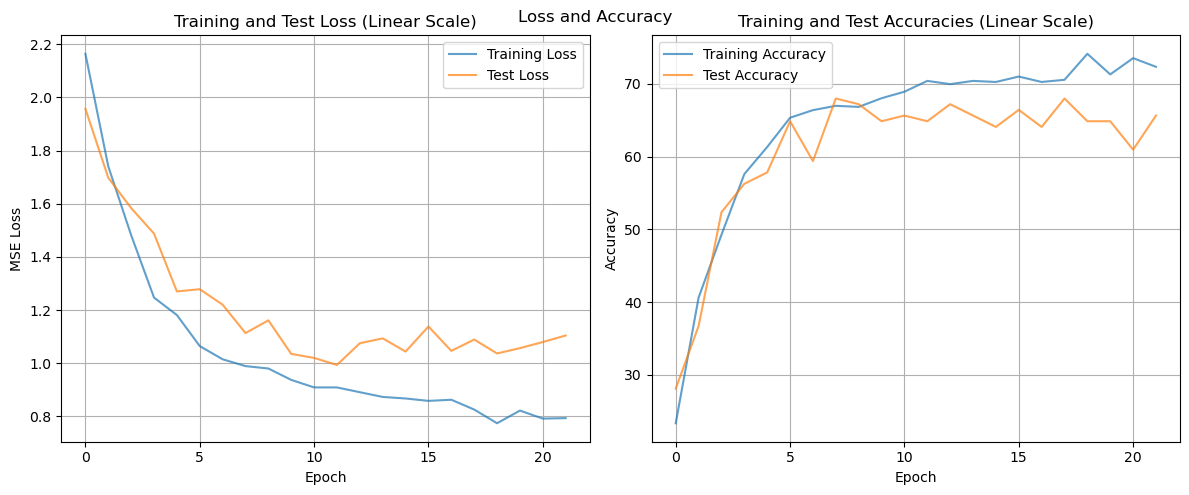

In [36]:
# Plot loss and accuracy
plot_loss_accuracy(train_losses_model_3, test_losses_model_3, train_accuracies_model_3, test_accuracies_model_3)

In [37]:
def evaluation_metrics(model, validation_features, validation_labels):
    y_true = validation_labels
    y_pred = torch.argmax(model(validation_features), dim=1)
    correct = (y_true == y_pred).sum().item()
    accuracy = correct / len(y_true)
    accuracy * 100

    TP = ((y_true == 1) & (y_pred == 1)).sum().item()
    FP = ((y_true == 0) & (y_pred == 1)).sum().item()
    FN = ((y_true == 1) & (y_pred == 0)).sum().item()
    
    precision = TP / (TP + FP + 1e-8)  # avoid division by zero
    recall = TP / (TP + FN + 1e-8)
    f1_Score = 2 * (precision * recall) / (precision + recall + 1e-8)

    return accuracy, precision, recall, f1_Score 

models = [model_1, model_2, model_3]  # Your actual model objects
for i, model in enumerate(models):
    accuracy, precision, recall, f1_score = evaluation_metrics(model, X_val, y_val)
    print(f"Model {i}: Accuracy={accuracy:.4f}, Precision={precision:.4f}, Recall={recall:.4f}, F1-Score={f1_score:.4f}")

Model 0: Accuracy=0.6950, Precision=1.0000, Recall=1.0000, F1-Score=1.0000
Model 1: Accuracy=0.8450, Precision=1.0000, Recall=1.0000, F1-Score=1.0000
Model 2: Accuracy=0.7250, Precision=1.0000, Recall=1.0000, F1-Score=1.0000


In [38]:
def confusion_matrix_fn(model, validation_features, validation_labels):
    y_true = validation_labels
    y_pred = torch.argmax(model(validation_features), dim=1)
    cm = confusion_matrix(y_true.cpu().numpy(), y_pred.cpu().numpy())
    return cm

print(confusion_matrix_fn(model_3, X_val, y_val))

[[13  0  2  0  0  0  1  0  0  0]
 [ 0 16  1  0  1  2  0  3  0  0]
 [ 1  1 18  0  2  0  1  1  0  3]
 [ 0  0  0 16  0  1  0  0  1  3]
 [ 0  0  2  1 15  0  0  0  0  0]
 [ 0  0  0  0  0  6  2  2  0  2]
 [ 0  0  2  0  0  0 14  2  0  0]
 [ 0  3  0  0  0  1  1 23  0  0]
 [ 2  5  0  2  0  1  0  0 11  0]
 [ 0  0  0  1  0  1  0  0  1 13]]


In [39]:
def classification_report_fn(model, validation_features, validation_labels):
    y_true = validation_labels
    y_pred = torch.argmax(model(validation_features), dim=1)
    report = classification_report(y_true.cpu().numpy(), y_pred.cpu().numpy())
    return report

print(classification_report_fn(model_3, X_val, y_val))

              precision    recall  f1-score   support

           0       0.81      0.81      0.81        16
           1       0.64      0.70      0.67        23
           2       0.72      0.67      0.69        27
           3       0.80      0.76      0.78        21
           4       0.83      0.83      0.83        18
           5       0.50      0.50      0.50        12
           6       0.74      0.78      0.76        18
           7       0.74      0.82      0.78        28
           8       0.85      0.52      0.65        21
           9       0.62      0.81      0.70        16

    accuracy                           0.72       200
   macro avg       0.72      0.72      0.72       200
weighted avg       0.73      0.72      0.72       200



In [40]:
def save_model(model, filepath, optimizer=None, epoch=None, loss=None, metadata=None):
    """
    Save a trained PyTorch model with optional additional information
    
    Args:
        model: Trained PyTorch model
        filepath: Path where to save the model
        optimizer: Optimizer state (optional)
        epoch: Training epoch (optional)
        loss: Final loss value (optional)
        metadata: Additional metadata dictionary (optional)
    """
    checkpoint = {
        'model_state_dict': model.state_dict(),
        'model_architecture': str(model),
    }
    
    # Add optional components
    if optimizer is not None:
        checkpoint['optimizer_state_dict'] = optimizer.state_dict()
    if epoch is not None:
        checkpoint['epoch'] = epoch
    if loss is not None:
        checkpoint['loss'] = loss
    if metadata is not None:
        checkpoint['metadata'] = metadata
    
    torch.save(checkpoint, filepath)
    print(f"Model saved to {filepath}")
    
    # Print summary
    print(f"Saved components: model_state_dict, model_architecture", end="")
    if optimizer is not None:
        print(", optimizer_state_dict", end="")
    if epoch is not None:
        print(f", epoch={epoch}", end="")
    if loss is not None:
        print(f", loss={loss:.4f}", end="")
    if metadata is not None:
        print(", metadata", end="")
    print()

In [41]:
# Save with training info
save_model(
    model=model_2,
    filepath='model_2_complete.pth',
    optimizer=optimizer,
    epoch=100,
    loss=test_losses_model_2[-1],
    metadata={
        'accuracy': test_accuracies_model_2[-1],
        'dataset': 'multiclass_example',
        'timestamp': datetime.datetime.now().isoformat()
    }
)

Model saved to model_2_complete.pth
Saved components: model_state_dict, model_architecture, optimizer_state_dict, epoch=100, loss=0.9198, metadata


In [42]:
def load_model(model, filepath, optimizer=None, device='cpu'):
    """
    Load a saved PyTorch model
    
    Args:
        model: Model architecture instance
        filepath: Path to saved model
        optimizer: Optimizer instance (optional)
        device: Device to load model on
    
    Returns:
        model: Loaded model
        optimizer: Loaded optimizer (if provided)
        checkpoint: Full checkpoint dictionary
    """
    checkpoint = torch.load(filepath, map_location=device, weights_only=True)
    model.load_state_dict(checkpoint['model_state_dict'])
    
    if optimizer is not None and 'optimizer_state_dict' in checkpoint:
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    
    print(f"Model loaded from {filepath}")
    print(f"Epoch: {checkpoint.get('epoch', 'N/A')}")
    print(f"Loss: {checkpoint.get('loss', 'N/A')}")
    
    return model, optimizer, checkpoint

In [43]:
# Create model instance with same architecture
loaded_model = TwoHiddenLayersMultiClassClassification(input_size=5, hidden_size=32, output_size=10).to(device) 
loaded_model, _, checkpoint = load_model(loaded_model, 'model_2_complete.pth')

Model loaded from model_2_complete.pth
Epoch: 100
Loss: 0.9198155291378498


In [44]:
# Evaluate the loaded model
print(evaluate_model(loaded_model, X_val, y_val))
# whether the evaluation result of the original model and saved-then-loaded model are equal or not?
print(evaluate_model(loaded_model, X_val, y_val)==evaluate_model(model_2, X_val, y_val))

(0.6365083456039429, tensor(84.5000))
True
